`mushi` demo
==

This notebook demonstrates how to use the Python module [`mushi`](https://github.com/harrispopgen/mushi/blob/master/mushi.py) for...

## Inferring mutation spectrum history (and demography)

>*the thing I came for:*\
*the wreck and not the story of the wreck*\
*the thing itself and not the myth*
>
>  – Adrienne Rich, Diving Into the Wreck

### Canon ball metaphor stolen from Erick Matsen

![](canon.svg)

In this metaphor, the pile of canonballs represents the mutation spectra we compute from SNPs, and the canon represents the mutational process.
Just as the history of how the canon was pointed and fired explains where we find the piles, the history of the mutation process explains the SNP mutation spectra we find in modern genomes.

We will use `mushi` to infer history of the mutation process, which we can think of as the mutation rate function over time for each triplet mutation type.
In `mushi`, we use coalescent theory and optimization techniques to learn about this history from the $k$-SFS.


### $3$-SFS from the 1000 Genomes Finnish population (previously computed by `mutyper`, see that demo)
Load the $k$-SFS

In [1]:
from mushi import kSFS
import pandas as pd

ksfs_df = pd.read_csv('example_data/3-SFS.EUR.FIN.tsv', sep='\t', index_col=0)
ksfs = kSFS(X=ksfs_df.values, mutation_types=ksfs_df.columns)

Plot the population variant spectrum (summing the $k$-SFS over sample frequency)

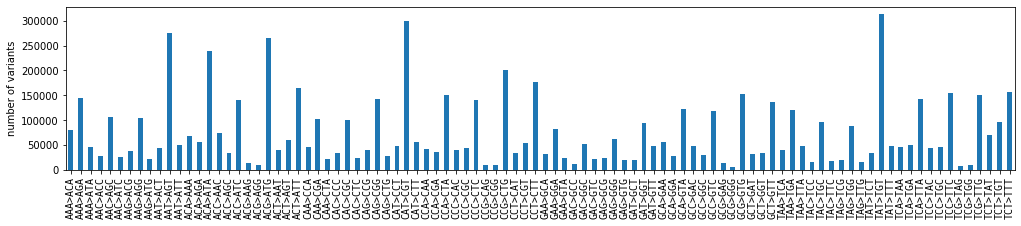

In [2]:
import matplotlib.pyplot as plt

ksfs_df.sum(0).plot.bar(figsize=(17, 3))
plt.xticks(family='monospace')
plt.ylabel('number of variants')
plt.show()

Plot the total SFS (summing the $k$-SFS over mutation types)

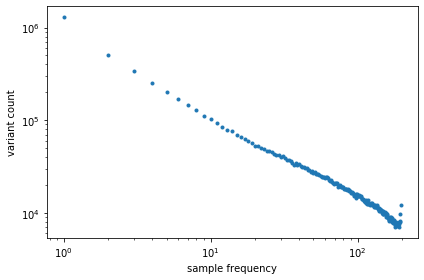

In [3]:
ksfs.plot_total()
plt.yscale('log')

plot k-SFS composition as a scatter (a color for each mutation type) and as a heatmap (a column for each mutation type)

/Users/williamdewitt/Applications/miniconda2/envs/mushi/lib/python3.7/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


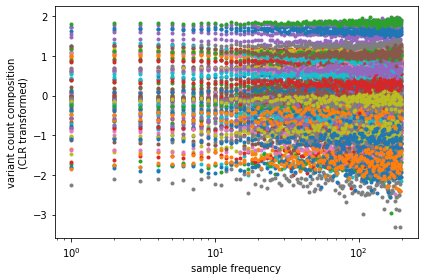

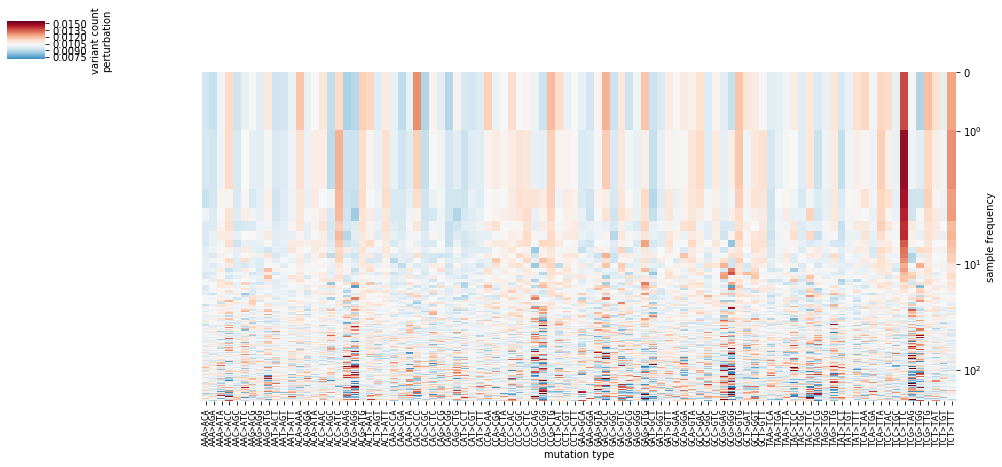

In [4]:
ksfs.plot(clr=True)
plt.show()

g = ksfs.clustermap(figsize=(17, 7), col_cluster=False, xticklabels=True, cmap='RdBu_r', rasterized=True,
                    vmin=1/96/1.5, vmax=1.5/96)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 9, family='monospace')
plt.show()

We will also need the masked genome size for each mutation type, which we've also previously computed with `mutyper`. This defines mutational target sizes.

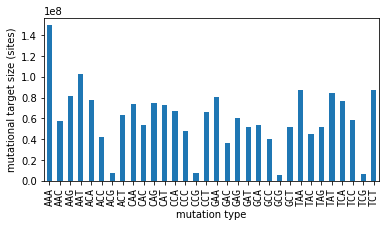

In [5]:
masked_genome_size = pd.read_csv(f'example_data/masked_size.tsv', sep='\t', header=None, index_col=0)
masked_genome_size.index.name='mutation type'

masked_genome_size.plot.bar(figsize=(6, 3), legend=False)
plt.xticks(family='monospace')
plt.ylabel('mutational target size (sites)')
plt.show()

With this we can compute the number of SNPs per target in each mutation type. Notice the enrichment of C>T transitions at CpG sites.

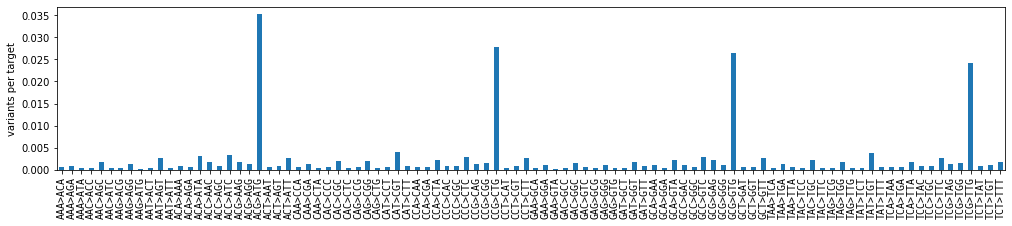

In [6]:
normalized_hit_rates = ksfs_df.sum(0).to_frame(name='variant count')
normalized_hit_rates['target size'] = [int(masked_genome_size.loc[context])
                                       for context, _ in normalized_hit_rates['variant count'].index.str.split('>')]

(normalized_hit_rates['variant count'] /
 normalized_hit_rates['target size']).plot.bar(figsize=(17, 3), legend=False)
plt.xticks(family='monospace')
plt.ylabel('variants per target')
plt.show()

To compute the total mutation rate in units of mutations per masked genome per generation, we multiply an estimate of the site-wise rate by the target size

In [7]:
μ0 = 1.25e-8 * masked_genome_size[1].sum()
μ0

24.05495735

To render time in years rather than generations, we use an estimate of the generation time

In [8]:
t_gen = 29

### Joint coalescent inference of demography and mutation spectrum history

To access time-calibrated mutation spectrum histories, we first need to estimate the demographic history, since this defines the diffusion timescale of the coalescent process.

We need to define a few parameters. The first is a grid of times will represent history on, measured retrospectively from the present in units of Wright-Fisher generations.

In [9]:
import numpy as np

t = np.logspace(np.log10(1), np.log10(200000), 200)

We now run the optimiztion. We set a few tuning parameters that control how complicated we are willing to let the inferred history function look. $\alpha$ parameters control demography and $\beta$ parameters control mutation spectrum history. We also define a tolerance for convergence.

In [10]:
ksfs.clear_eta()
ksfs.clear_mu()
ksfs.infer_history(t, μ0,
                   alpha_tv=1e2, alpha_spline=3e3, alpha_ridge=1e-10,
                   beta_rank=1e1, beta_tv=7e1, beta_spline=1e1, beta_ridge=1e-10,
                   tol=1e-11)

inferring η(t)
initial objective -7.451393e+07
iteration 431, objective -7.460e+07, relative change 6.576e-12                                                               
relative change in objective function 6.6e-12 is within tolerance 1e-11 after 431 iterations
inferring μ(t) conditioned on η(t)
initial objective -4.465144e+07
iteration 300, objective -4.466e+07, relative change 8.497e-12        
relative change in objective function 8.5e-12 is within tolerance 1e-11 after 300 iterations


I hope you agree that was fast. 🏎

We'll now check that the demography has a few features we expect in the Finnish population: the out-of-Africa bottleneck shared by all Eurasians, a later bottleneck associated with northward migration, and exponential population growth toward the present.

The plot on the left shows how good of a job we do at fitting the SFS, and the plot on the right is the inferred haploid effective population size history.

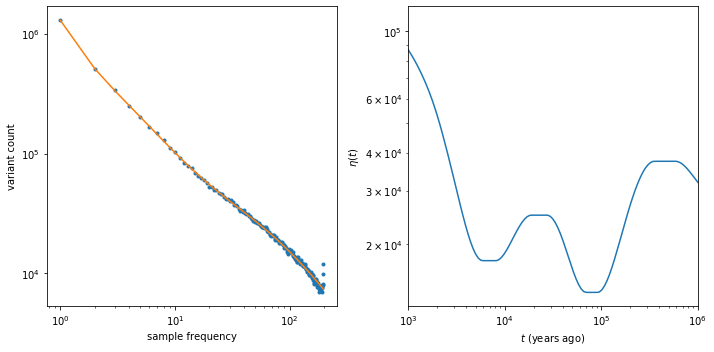

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
ksfs.plot_total()
plt.subplot(122)
ksfs.eta.plot(t_gen=t_gen)
plt.xlim([1e3, 1e6])
plt.show()

Now let's take a look at the inferred mutation spectrum history (MuSH).
The plot on the left shows the measured $k$-SFS composition (points) and the fit from `mushi` (lines).

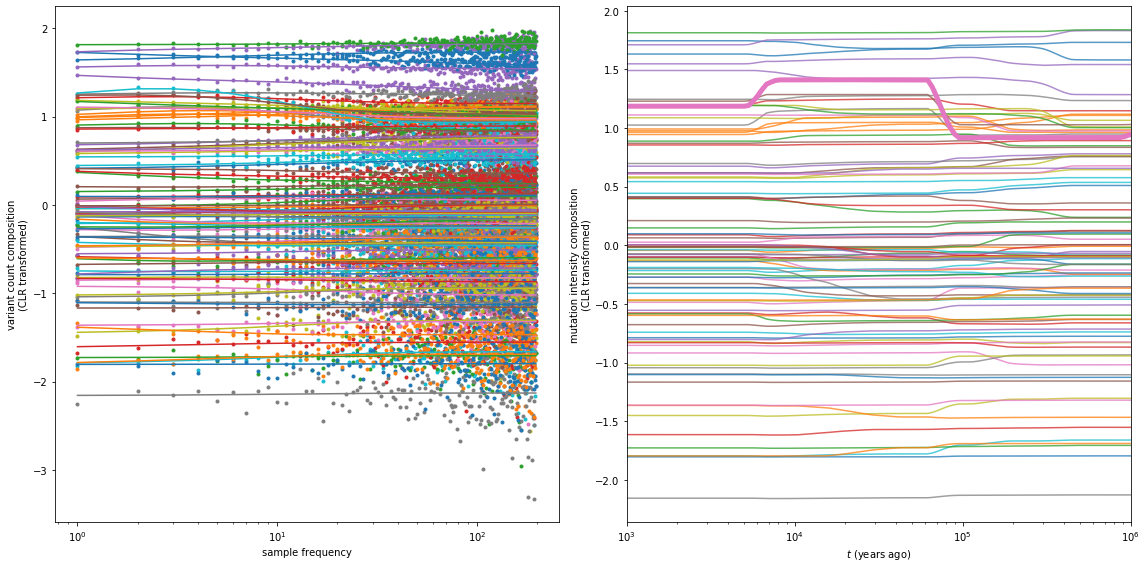

In [12]:
plt.figure(figsize=(16, 8))
plt.subplot(121)            
ksfs.plot(clr=True)            
plt.subplot(122)
ksfs.μ.plot(t_gen=t_gen, clr=True, alpha=0.75)
ksfs.μ.plot(('TCC>TTC',), t_gen=t_gen, clr=True, lw=5)
plt.xscale('log')
plt.xlim([1e3, 1e6])          
plt.show()

We can also plot the MuSH as a heatmap with the y axis representing time.

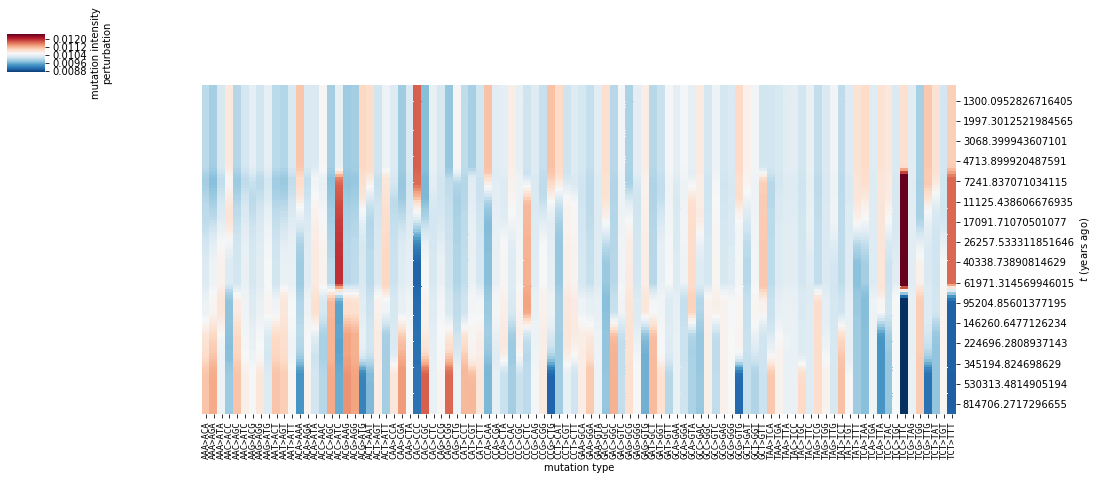

In [13]:
g = ksfs.μ.clustermap(t_gen=t_gen, figsize=(17, 7), col_cluster=False, xticklabels=True,
                                vmin=1/96/1.2, vmax=1.2/96,
                                cmap='RdBu_r')
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 9, family='monospace')
g.ax_heatmap.set_ylim([172, 58])
plt.show()

Now that you have a MuSH, you can start answering questions about mutation spectrum history!🤸‍